In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as pd
import pandas as pd
import cv2
import pydicom
import scipy

from sklearn.model_selection import train_test_split, StratifiedKFold
from matplotlib import pyplot as plt
from utils.mask_functions import *
from glob import glob
from PIL import Image
from scipy.sparse import load_npz
from keras_tqdm import TQDMNotebookCallback
from tqdm import tqdm_notebook

import tensorflow as tf
import keras
from keras.applications.resnet50 import ResNet50
from keras_applications.resnext import ResNeXt50
from keras.utils import Sequence
from keras.preprocessing.image import load_img
from keras.models import Model, model_from_json
from keras.layers import Input, LeakyReLU, core, Dropout, BatchNormalization, Concatenate, Dense, Flatten, GlobalAveragePooling2D
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.losses import binary_crossentropy
from keras.optimizers import SGD, Adam
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
# Restrict to single GPU
os.environ["CUDA_VISIBLE_DEVICES"]='0'

### Parse Data - Create Annotations

In [3]:
train_path = './siim/dicom-images-train/*/*/*.dcm'
mask_path = './siim/train-rle.csv'
images_to_ram = True # Low or high memory usage
img_height = 512
img_width = 512
n_channels = 3
batch_size = 8
epochs = 500

In [4]:
def get_train_df(train_path=train_path, mask_path=mask_path, images_to_ram=False, mask_img=False):
    rles_df = pd.read_csv(mask_path)
    rles_df.columns = ['ImageId', 'EncodedPixels']
        
    metadata_list = []
    train_fps = glob(train_path)

    if images_to_ram is True:
        img_dict = {}
    for i, fp in tqdm_notebook(enumerate(train_fps)):
        metadata = {}
        dcm = pydicom.dcmread(fp)
        metadata['ImageId'] = dcm.SOPInstanceUID
        metadata['FilePath'] = fp
        
        encoded_pixels_list = rles_df[rles_df['ImageId']==dcm.SOPInstanceUID]['EncodedPixels'].values
        pneumothorax = False
        for encoded_pixels in encoded_pixels_list:
            if encoded_pixels != ' -1':
                pneumothorax = True
        
        metadata['Pneumothorax'] = pneumothorax
        
        if images_to_ram is True:
            metadata['PixelArray'] = dcm.pixel_array
            if mask_img is True:
                if pneumothorax is True:
                    metadata['EncodedPixels'] = load_npz('siim/mask/'+dcm.SOPInstanceUID+'.npz').todense().astype('uint8')
                else:
                    metadata['EncodedPixels'] = np.zeros((1024, 1024))
                
        metadata_list.append(metadata)

    return pd.DataFrame(metadata_list)

In [5]:
df = get_train_df(train_path, mask_path, images_to_ram)

In [6]:
df.head()

,ImageId,FilePath,Pneumothorax,PixelArray
0,1.2.276.0.7230010.3.1.4.8323329.31935.15178751...,./siim/dicom-images-train/1.2.276.0.7230010.3....,False,"[[1, 2, 3, 3, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3,..."
1,1.2.276.0.7230010.3.1.4.8323329.4297.151787518...,./siim/dicom-images-train/1.2.276.0.7230010.3....,True,"[[1, 0, 1, 0, 0, 3, 0, 0, 2, 1, 1, 0, 0, 0, 0,..."
2,1.2.276.0.7230010.3.1.4.8323329.12953.15178752...,./siim/dicom-images-train/1.2.276.0.7230010.3....,False,"[[0, 1, 2, 3, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2,..."
3,1.2.276.0.7230010.3.1.4.8323329.12901.15178752...,./siim/dicom-images-train/1.2.276.0.7230010.3....,False,"[[86, 87, 88, 88, 88, 88, 87, 86, 86, 86, 86, ..."
4,1.2.276.0.7230010.3.1.4.8323329.12036.15178752...,./siim/dicom-images-train/1.2.276.0.7230010.3....,False,"[[153, 139, 123, 107, 94, 84, 75, 65, 57, 52, ..."


### Split and Balance the Data

In [7]:
# Imbalance between Pos and Neg classifications:
len(df[df.Pneumothorax == True]), len(df[df.Pneumothorax == False])

(2379, 8296)

In [8]:
train_df, val_df = train_test_split(df, stratify=df.Pneumothorax, test_size=0.2, random_state=88)

img_height = 1024
img_width = 1024
batch_size = 16

In [9]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, data_frame,
                 batch_size=4,
                 img_height=512,
                 img_width=512,
                 n_channels=3,
                 augmentations=None,
                 shuffle=True):
        self.data_frame = data_frame
        self.batch_size = batch_size
        self.img_height = img_height
        self.img_width = img_width
        self.n_channels = n_channels
        self.augment = augmentations
        self.shuffle = shuffle
        #self.indexes = np.arange(len(self.data_frame))
        self.on_epoch_end()
        
    def __len__(self):
        'Batches per epoch'
        return int(np.ceil(len(self.data_frame) / self.batch_size))
    
    def on_epoch_end(self):
        'Update indexes when epoch ends'
        self.indexes = np.arange(len(self.data_frame))
        if self.shuffle == True:
            #self.indexes = np.arange(len(self.data_frame))
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index):
        'Get one batch'
        batch_indexes = self.indexes[index*self.batch_size:min((index+1)*self.batch_size,len(self.data_frame))]
        
        batch_x, batch_y = self.data_generation(batch_indexes)
        
        if self.augment is None:
            return np.array(batch_x)/255, np.array(batch_y)
        else:
            return np.stack([self.augment(image=x)['image'] for x in batch_x], axis=0), np.array(batch_y)
        
    def data_generation(self, batch_indexes):
        if 'PixelArray' in self.data_frame.columns:
            X = [cv2.resize(img, (self.img_height, self.img_width)) for img in self.data_frame.iloc[batch_indexes]['PixelArray']]
        else:   
            fps = self.data_frame.iloc[batch_indexes].FilePath
            X = np.empty((len(fps), self.img_height, self.img_width))
            for i, fp in enumerate(fps):
                dcm = pydicom.dcmread(fp)
                X[i] = cv2.resize(dcm.pixel_array, (self.img_height, self.img_width))
        # Gray img to rgb
        X = np.stack([X, X, X], axis=3)

        Y = pd.concat([np.invert(self.data_frame.iloc[batch_indexes]['Pneumothorax'])+0,
                      self.data_frame.iloc[batch_indexes]['Pneumothorax']+0],
                      axis=1) 
        
        return np.uint8(X), np.uint8(Y)

In [10]:
from albumentations import (
    Compose, HorizontalFlip, CLAHE, HueSaturationValue,
    RandomBrightness, RandomContrast, RandomGamma,OneOf,
    ToFloat, ShiftScaleRotate, GridDistortion, ElasticTransform, JpegCompression, HueSaturationValue,
    RGBShift, RandomBrightness, RandomContrast, GaussNoise, CenterCrop,
    IAAAdditiveGaussianNoise, GaussNoise, RandomSizedCrop
)

AUGMENTATIONS_TRAIN = Compose([
    HorizontalFlip(p=0.5),
    RandomGamma(p=0.5),
    GridDistortion(p=0.5),
    ShiftScaleRotate(
        shift_limit=0.05,
        scale_limit=0.1,
        rotate_limit=10,
        border_mode=cv2.BORDER_CONSTANT,
        p=0.5
    ),
    RandomSizedCrop(min_max_height=(int(0.9*img_height), img_height), height=img_height, width=img_width, p=0.5),
    CLAHE(),
    ToFloat()
], p=1)


AUGMENTATIONS_TEST = Compose([
    CLAHE(),
    ToFloat()
], p=1)

# Add Gamma correction to test
#from imgaug import augmenters as iaa
#seq = iaa.Sequential([iaa.GammaContrast(1.2)])

### Check Augmentations

In [11]:
def plot_pixel_array(data, figsize=(10,10)):
    plt.figure(figsize=figsize)
    plt.imshow(data, cmap=plt.cm.bone)
    plt.show()
    
def plot_pixel_array_overlay(data, label, figsize=(10,10)):
    plt.figure(figsize=figsize)
    plt.imshow(data, cmap=plt.cm.bone)
    plt.imshow(label, alpha=.3)
    plt.show()
    
def plot_grid(imgs, grid_width, grid_height):
    max_imgs = grid_width*grid_height
    plt.clf()
    fig, axes = plt.subplots(grid_height, grid_width, figsize=(16, 12))
    
    for i, img in zip(range(max_imgs), imgs):
        ax = axes[int(i/grid_width), i%grid_width]
        ax.imshow(img, cmap='bone')
        ax.axis('off')
    
    plt.show()

<Figure size 432x288 with 0 Axes>

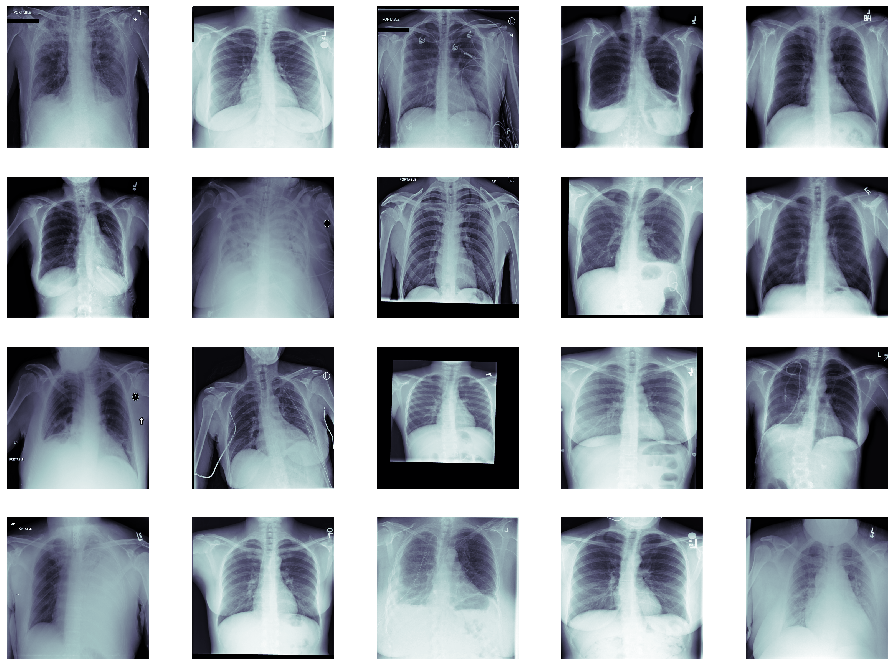

(0.0, 1.0, (20, 512, 512, 3), (512, 512, 3), (20, 2))

In [12]:
a = DataGenerator(data_frame=train_df, batch_size=20, shuffle=False,
                 img_height=img_height, img_width=img_width, n_channels=n_channels)
imgs, masks = a.__getitem__(0)
plot_grid(imgs[:,:,:,0], 5, 4)
imgs[0].min(), imgs[0].max(), imgs.shape, imgs[0].shape, masks.shape

<Figure size 432x288 with 0 Axes>

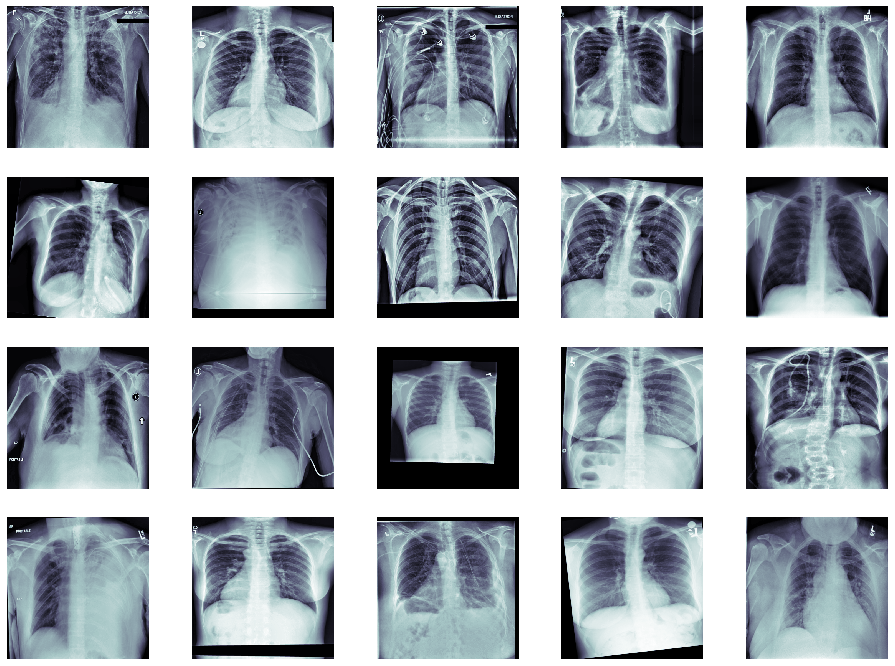

(0.007843138, 0.99215686, (20, 512, 512, 3), (512, 512, 3))

In [13]:
# Augmented
b = DataGenerator(data_frame=train_df, batch_size=20, augmentations=AUGMENTATIONS_TRAIN, shuffle=False,
                 img_height=img_height, img_width=img_width, n_channels=n_channels)
imgs, masks = b.__getitem__(0)
plot_grid(imgs[:,:,:,0], 5, 4)
imgs[0].min(), imgs[0].max(), imgs.shape, imgs[0].shape

### Balance Data

### Data Loader with Augmentations

### Finetune Pretrained Networks

In [14]:
def get_resnet50(img_height=img_height, img_width=img_width, n_channels=n_channels):
    inputs = Input(shape=(img_height, img_width, n_channels))
    #conc = Concatenate()([inputs, inputs, inputs])
    
    base = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs, classes=2)
    
    for layer in base.layers:
        layer.trainable = True
    
    outputs = GlobalAveragePooling2D()(base.output)
    outputs = Dense(2, activation='softmax')(outputs)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

def get_resnext50(img_height=img_height, img_width=img_width, n_channels=n_channels):
    inputs = Input(shape=(img_height, img_width, n_channels))
    #conc = Concatenate()([inputs, inputs, inputs])
    
    base = ResNeXt50(include_top=False, weights='imagenet', input_tensor=inputs, classes=2,
                    backend = keras.backend, layers = keras.layers, models = keras.models, utils = keras.utils)
    
    for layer in base.layers:
        layer.trainable = True
    
    outputs = GlobalAveragePooling2D()(base.output)
    outputs = Dense(2, activation='softmax')(outputs)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [15]:
K.clear_session()
model = get_resnet50()
model.summary()

W0825 00:37:24.347444 140099260716800 deprecation_wrapper.py:119] From /opt/conda/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0825 00:37:24.348846 140099260716800 deprecation_wrapper.py:119] From /opt/conda/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0825 00:37:24.366543 140099260716800 deprecation_wrapper.py:119] From /opt/conda/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0825 00:37:24.367790 140099260716800 deprecation_wrapper.py:119] From /opt/conda/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W082

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 256, 256, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [18]:
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.00001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint('./save/resnet50_best.h5', monitor='val_acc', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(patience=25)

In [19]:
training_generator = DataGenerator(data_frame=train_df,
                                   img_height=img_height,
                                   img_width=img_width,
                                   n_channels=n_channels,
                                   batch_size=batch_size,
                                   augmentations=AUGMENTATIONS_TRAIN)
validation_generator = DataGenerator(data_frame=val_df,
                                     img_height=img_height,
                                     img_width=img_width,
                                     n_channels=n_channels,
                                     batch_size=batch_size,
                                     augmentations=AUGMENTATIONS_TEST)
history = model.fit_generator(generator=training_generator,
                              validation_data=validation_generator,
                              use_multiprocessing=False,
                              epochs=epochs,
                              verbose=1,
                              callbacks=[early_stopping, checkpointer])

Epoch 1/500
1068/1068 [==============================] - 290s 271ms/step - loss: 0.3430 - acc: 0.8485 - val_loss: 0.3892 - val_acc: 0.8281

Epoch 00001: val_acc improved from -inf to 0.82810, saving model to ./save/resnet50_best.h5
Epoch 2/500
1068/1068 [==============================] - 274s 257ms/step - loss: 0.3168 - acc: 0.8605 - val_loss: 0.3204 - val_acc: 0.8562

Epoch 00002: val_acc improved from 0.82810 to 0.85621, saving model to ./save/resnet50_best.h5
Epoch 3/500
1068/1068 [==============================] - 274s 257ms/step - loss: 0.2995 - acc: 0.8696 - val_loss: 0.3163 - val_acc: 0.8604

Epoch 00003: val_acc improved from 0.85621 to 0.86042, saving model to ./save/resnet50_best.h5
Epoch 4/500
1068/1068 [==============================] - 272s 255ms/step - loss: 0.2870 - acc: 0.8791 - val_loss: 0.3601 - val_acc: 0.8506

Epoch 00004: val_acc did not improve from 0.86042
Epoch 5/500
1068/1068 [==============================] - 276s 258ms/step - loss: 0.2811 - acc: 0.8780 - val_

In [20]:
model.save_weights('./save/resnet50_final.h5', overwrite=True)

### Sanity Check on Validation

In [21]:
model.load_weights('./save/resnet50_best.h5')

In [22]:
validation_generator = DataGenerator(data_frame=val_df,
                                     img_height=img_height,
                                     img_width=img_width,
                                     n_channels=n_channels,
                                     batch_size=batch_size,
                                     augmentations=AUGMENTATIONS_TEST,
                                     shuffle=False)
preds_val = model.predict_generator(validation_generator)

In [24]:
accuracy = np.mean(np.equal(np.argmax(preds_val, axis=-1), np.array(val_df['Pneumothorax']+0)))
print(accuracy)

0.8824355971896956


### Stats

In [ ]:
# history